In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dsb_data_dir = os.path.join('..', 'input')
stage_label = 'stage1'

In [2]:
train_labels = pd.read_csv(os.path.join(dsb_data_dir,'{}_train_labels.csv'.format(stage_label)))

In [3]:
train_labels['EncodedPixels'] = train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])

In [3]:
all_images = glob(os.path.join(dsb_data_dir, 'stage1_*', '*', '*', '*'))
img_df = pd.DataFrame({'path': all_images})
img_id = lambda in_path: in_path.split('/')[-3]
img_type = lambda in_path: in_path.split('/')[-2]
img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
img_df['ImageId'] = img_df['path'].map(img_id)
img_df['ImageType'] = img_df['path'].map(img_type)
img_df['TrainingSplit'] = img_df['path'].map(img_group)
img_df['Stage'] = img_df['path'].map(img_stage)
img_df.sample(2)

,path,ImageId,ImageType,TrainingSplit,Stage
20573,../input/stage1_train/2227fd9b01d67c2bcdb407d3...,2227fd9b01d67c2bcdb407d3205214e6dfeff9fd072582...,masks,train,stage1
13098,../input/stage1_train/e66a97b2c77f3d66a7d3cebb...,e66a97b2c77f3d66a7d3cebbc6a36c8c6259368a397f7b...,masks,train,stage1


In [4]:
img_id

<function __main__.<lambda>>

In [71]:
%%time
train_df = img_df.query('TrainingSplit=="train"')
train_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in train_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    train_rows += [c_row]
train_img_df = pd.DataFrame(train_rows)    
IMG_CHANNELS = 3
def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))

CPU times: user 30.4 s, sys: 2.78 s, total: 33.2 s
Wall time: 48.4 s


In [72]:
%%time
test_df = img_df.query('TrainingSplit=="test"')
test_rows = []
group_cols = ['Stage', 'ImageId']
for n_group, n_rows in test_df.groupby(group_cols):
    c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
    #c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
    c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
    test_rows += [c_row]
test_img_df = pd.DataFrame(test_rows)    
IMG_CHANNELS = 3
#def read_and_stack(in_img_list):
    #return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0
test_img_df['images'] = test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
#train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))

CPU times: user 596 ms, sys: 8 ms, total: 604 ms
Wall time: 700 ms


In [73]:
X=train_img_df['images']
Y=train_img_df['masks']
X_t=test_img_df['images']
len(X_t)
X_t.shape

(65,)

In [74]:
from skimage.transform import resize

l=X.shape[0]
images=[None]*l
masks=[None]*l
for i in range(l):
    images[i]=resize(X[i],(256, 256,3), mode='constant', preserve_range=True)
    masks[i]=resize(Y[i],(256, 256,1), mode='constant', preserve_range=True)
    masks[i]=masks[i].astype(int)
    
images=np.asarray(images)
masks=np.asarray(masks)

In [75]:
from skimage.transform import resize

l=X_t.shape[0]
images_test=[None]*l
for i in range(l):
    images_test[i]=resize(X[i],(256, 256,3), mode='constant', preserve_range=True)
    
images_test=np.asarray(images_test)


In [76]:
images_test[1]

array([[[ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01960784,  0.01960784,  0.01960784],
        ..., 
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01568627,  0.01568627,  0.01568627]],

       [[ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01568627,  0.01568627,  0.01568627],
        ..., 
        [ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01960784,  0.01960784,  0.01960784],
        [ 0.01568627,  0.01568627,  0.01568627]],

       [[ 0.02352941,  0.02352941,  0.02352941],
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01960784,  0.01960784,  0.01960784],
        ..., 
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01568627,  0.01568627,  0.01568627],
        [ 0.01568627,  0.01568627,  0.01568627]],

       ..., 
       [[ 0.02352941,  0.02352941,  0.02352941],
        

In [77]:
from keras.preprocessing.image import ImageDataGenerator

In [9]:
# datagen = ImageDataGenerator(
#         rotation_range=40,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True,
#         fill_mode='nearest')

In [78]:
#https://www.kaggle.com/c0conuts/unet-imagedatagenerator-lb-0-336

datagen=ImageDataGenerator(shear_range=0.5, 
                   rotation_range=50, 
                   zoom_range=0.2, 
                   width_shift_range=0.2, 
                   height_shift_range=0.2,
                   fill_mode='reflect')


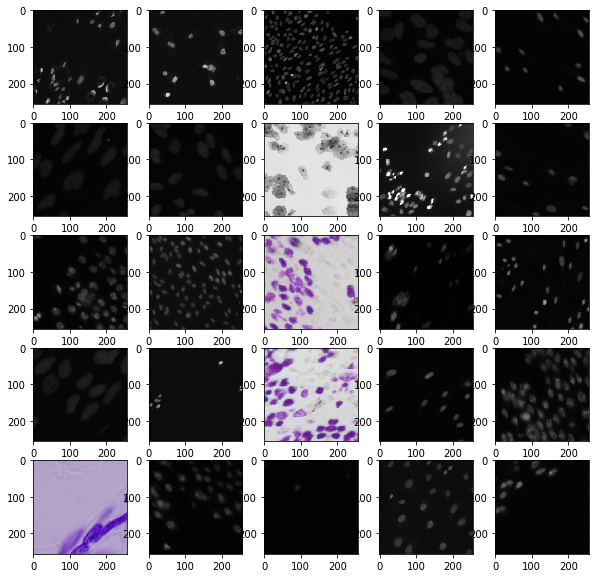

In [79]:
i=1
k=25
fig = plt.figure(figsize=(10, 10)) 
for X_batch in datagen.flow(images, batch_size=1,seed=1):
    #fig = plt.figure(figsize=(8, 6)) 
    plt.subplot(5,5,i)
    plt.imshow(X_batch[0])
    i+=1
    if i>k:
        break
plt.show()

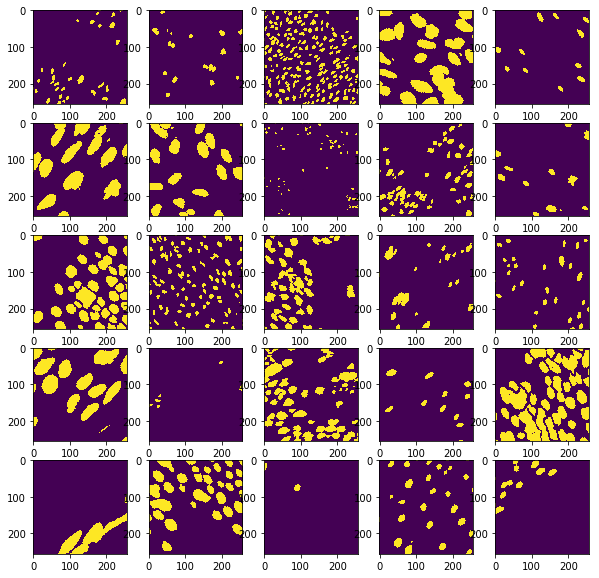

In [80]:
i=1
k=25
fig = plt.figure(figsize=(10, 10)) 

for y_batch in datagen.flow(masks, batch_size=1,seed=1):
    plt.subplot(5,5,i)
    plt.imshow(y_batch[0][:,:,0])
    i+=1
    if i>k:
        break
plt.show()

In [81]:
%%time
i=1
k=2500
#fig = plt.figure(figsize=(10, 10)) 
images_aug=images
for X_batch in datagen.flow(images, batch_size=1,seed=1):
    x=X_batch[0]
    x = x.reshape((1,) + x.shape)
    images_aug=np.vstack((images_aug,x))
    i+=1
    if i>k:
        break


CPU times: user 14min 37s, sys: 11min 51s, total: 26min 29s
Wall time: 26min 32s


In [82]:
%%time
i=1
k=2500
#fig = plt.figure(figsize=(10, 10)) 
masks_aug=masks
for y_batch in datagen.flow(masks, batch_size=1,seed=1):
    y=y_batch[0]
    y = y.reshape((1,) + y.shape)
    masks_aug=np.vstack((masks_aug,y))
    i+=1
    if i>k:
        break

CPU times: user 4min 24s, sys: 2min 12s, total: 6min 36s
Wall time: 6min 39s


In [86]:
images_aug.shape
masks_aug.shape

(3170, 256, 256, 1)

In [87]:
import tensorflow as tf

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [120]:
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Build U-Net model
inputs = Input((256, 256, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
lambda_3 (Lambda)                (None, 256, 256, 3)   0           input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_39 (Conv2D)               (None, 256, 256, 16)  448         lambda_3[0][0]                   
____________________________________________________________________________________________________
dropout_19 (Dropout)             (None, 256, 256, 16)  0           conv2d_39[0][0]                  
___________________________________________________________________________________________

In [126]:
import h5py

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
model.fit(images_aug, masks_aug, validation_split=0.2, batch_size=32, epochs=50,
                    callbacks=[earlystopper,checkpointer], shuffle=True)

Train on 2536 samples, validate on 634 samples
Epoch 1/50
2536/2536 [==============================] - 1166s - loss: 0.2696 - my_iou_metric: 0.0138 - val_loss: 0.2828 - val_my_iou_metric: 0.0314
Epoch 2/50
2536/2536 [==============================] - 1136s - loss: 0.1871 - my_iou_metric: 0.0184 - val_loss: 0.1493 - val_my_iou_metric: 0.0320
Epoch 3/50
2536/2536 [==============================] - 1134s - loss: 0.1375 - my_iou_metric: 0.0294 - val_loss: 0.2387 - val_my_iou_metric: 0.0350
Epoch 4/50
2536/2536 [==============================] - 1367s - loss: 0.1289 - my_iou_metric: 0.0312 - val_loss: 0.1484 - val_my_iou_metric: 0.0237
Epoch 5/50
2536/2536 [==============================] - 1774s - loss: 0.1160 - my_iou_metric: 0.0325 - val_loss: 0.1037 - val_my_iou_metric: 0.0511
Epoch 6/50
2536/2536 [==============================] - 1564s - loss: 0.0977 - my_iou_metric: 0.0386 - val_loss: 0.0947 - val_my_iou_metric: 0.0563
Epoch 7/50
2536/2536 [==============================] - 1098s - l

2536/2536 [==============================] - 1160s - loss: 0.0711 - my_iou_metric: 0.0587 - val_loss: 0.0710 - val_my_iou_metric: 0.0710
Epoch 28/50
2536/2536 [==============================] - 1134s - loss: 0.0710 - my_iou_metric: 0.0596 - val_loss: 0.0689 - val_my_iou_metric: 0.0713
Epoch 29/50
2536/2536 [==============================] - 1150s - loss: 0.0692 - my_iou_metric: 0.0592 - val_loss: 0.0670 - val_my_iou_metric: 0.0740
Epoch 30/50
2536/2536 [==============================] - 1159s - loss: 0.0697 - my_iou_metric: 0.0630 - val_loss: 0.0732 - val_my_iou_metric: 0.0719
Epoch 31/50
2536/2536 [==============================] - 1206s - loss: 0.0719 - my_iou_metric: 0.0595 - val_loss: 0.0684 - val_my_iou_metric: 0.0793
Epoch 32/50
2536/2536 [==============================] - 1157s - loss: 0.0685 - my_iou_metric: 0.0615 - val_loss: 0.0696 - val_my_iou_metric: 0.0836
Epoch 33/50
2536/2536 [==============================] - 1115s - loss: 0.0672 - my_iou_metric: 0.0631 - val_loss: 0.06

In [99]:
model.fit(images_aug, masks_aug, validation_split=0.2, batch_size=32, epochs=50, shuffle=True)

Train on 2536 samples, validate on 634 samples
Epoch 1/50
2536/2536 [==============================] - 1142s - loss: 0.0635 - my_iou_metric: 0.0657 - val_loss: 0.0671 - val_my_iou_metric: 0.0831
Epoch 2/50
2536/2536 [==============================] - 1286s - loss: 0.0629 - my_iou_metric: 0.0677 - val_loss: 0.0649 - val_my_iou_metric: 0.0836
Epoch 3/50
2536/2536 [==============================] - 1466s - loss: 0.0641 - my_iou_metric: 0.0671 - val_loss: 0.0643 - val_my_iou_metric: 0.0797
Epoch 4/50
2536/2536 [==============================] - 1644s - loss: 0.0617 - my_iou_metric: 0.0666 - val_loss: 0.0636 - val_my_iou_metric: 0.0855
Epoch 5/50
2536/2536 [==============================] - 1791s - loss: 0.0610 - my_iou_metric: 0.0674 - val_loss: 0.0616 - val_my_iou_metric: 0.0834
Epoch 6/50
2536/2536 [==============================] - 1917s - loss: 0.0603 - my_iou_metric: 0.0718 - val_loss: 0.0607 - val_my_iou_metric: 0.0853
Epoch 7/50
2536/2536 [==============================] - 2011s - l

KeyboardInterrupt: 

In [127]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'my_iou_metric': my_iou_metric})
i=100
p=model.predict(images_aug[i:i+1,:,:,:])
p=p[0,:,:,0]
p.shape

(256, 256)

In [128]:
a=np.where(p>0.5,1,0)

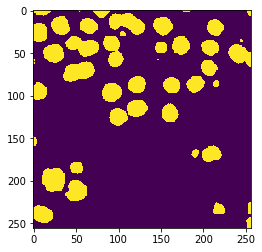

In [129]:
plt.imshow(a)

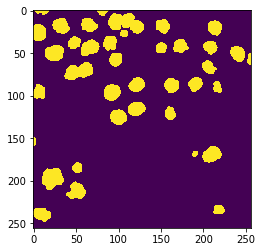

In [130]:
plt.imshow(masks_aug[i,:,:,0])

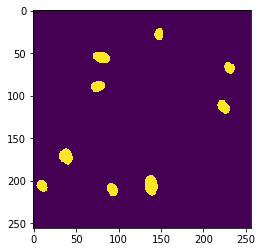

In [115]:
i=60
p_t=model.predict(images_test[i:i+1,:,:,:])
p_t=p_t[0,:,:,0]
a_t=np.where(p_t>0.5,1,0)
plt.imshow(a_t)


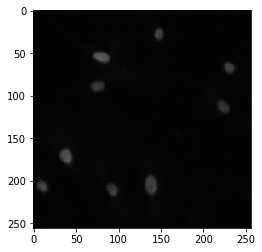

In [116]:
plt.imshow(images_test[i])
#images_test[i].shape

In [117]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [118]:
import cv2
import pandas as pd
from scipy import ndimage

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = cv2.imread(str(im_path),1)
    im=resize(im,(256,256,3))
    im=np.array([im])
    #im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    
    p = model.predict(im)
    p=p[0,:,:,0]
    
    
    #thresh_val = threshold_otsu(p)
    mask = np.where(p > 0.5, 1, 0)
    
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [119]:
import pathlib
import time
t0 = time.time()

testing = pathlib.Path('../input/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submissionUnetAug2500_1.csv', index=None)

t1=time.time()
total=t1-t0
print(total)

15.6165239811


In [50]:
len(df)

2603